In [21]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single

In [24]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence
from cohlib.sample import sample_spikes_from_xs

In [33]:
fs = 1000
seed = 8

win=1000
L=25
C=1
emiter=25
alpha=50
K=2

alpha=float(alpha)

sample_length = win
em_iters = emiter

data_path = f'saved/synthetic_data/simple_synthetic_deltarelupoisson_fixed_gamma_{K}_{L}_{sample_length}'
data_load = pickle_open(data_path)
latent = data_load['latent']
Gamma = latent['Gamma']
zs = latent['zs']
xs = latent['xs']
# obs = data_load['observed']
alphas = np.array([alpha for k in range(K)])

lams = cif_alpha_relu(alphas, xs)
spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
Gamma_zest = Gamma_est_from_zs(zs)
# data_path = f'saved/synthetic_data/simple_synthetic_deltarelupoisson_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}'
# data_load = pickle_open(data_path)
# latent = data_load['latent']
# Gamma = latent['Gamma']
# zs = latent['zs']
# xs = latent['xs']
# obs = data_load['observed']
# lams = obs['lams']
# spikes = obs['spikes']
# Gamma_zest = Gamma_est_from_zs(zs)

model_path = f'saved/fitted_models/simple_synthetic_deltarelupoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
model_load = pickle_open(model_path)
Gamma_est = model_load['Gamma']


Text(0.5, 1.0, 'Firing Rates')

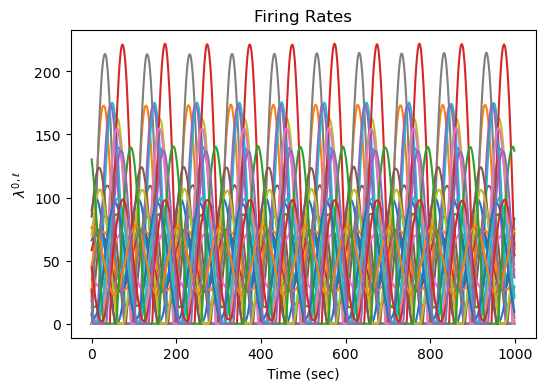

In [34]:
time = np.arange(1000)*1e-3
lams.shape
fig, ax = plt.subplots(figsize=(6,4))
for l in range(L):
    ax.plot(lams[l,0,:])
ax.set_xlabel('Time (sec)')
ax.set_ylabel(r'$\lambda^{0,\ell}$')
ax.set_title('Firing Rates')


In [35]:
from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence
# spikes_mc = (spikes[:L,:C,0,:] - spikes[:L,:C,0,:].mean(2)[:,:,None]).mean(1)
# spikes_mc = spikes
spikes_mc = spikes.mean(1)
# ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
S_naive = S_naive[:,1:51]

ft_spikes0 = ft_spikes[:,0,1:]
ft_spikes1 = ft_spikes[:,1,1:]

coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
coh_naive = coh_naive[:50]

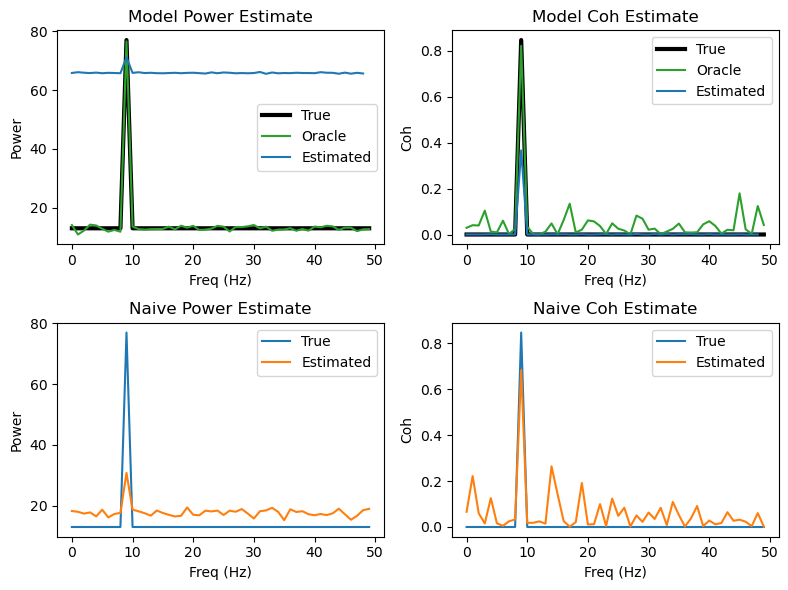

In [36]:
coh_true = thr_coherence(Gamma[:50,:,:])
coh_model = thr_coherence(Gamma_est[:50,:,:])
coh_oracle = thr_coherence(Gamma_zest[:50,:,:])

S_true = Gamma[:50,0,0].real
S_model = Gamma_est[:50,0,0].real
S_oracle = Gamma_zest[:50,0,0].real

logS = True

if logS is True:
    S_true = 10*np.log10(S_true)
    S_model = 10*np.log10(S_model)
    S_naive = 10*np.log10(S_naive)
    S_oracle = 10*np.log10(S_oracle)

fig, ax = plt.subplots(2,2, figsize=(8,6))
ax[0,0].plot(S_true, label='True', color='k', linewidth=3)
ax[0,0].plot(S_oracle, label='Oracle', color='tab:green')
ax[0,0].plot(S_model, label='Estimated')
ax[0,0].set_ylabel('Power')
ax[0,0].set_xlabel('Freq (Hz)')
ax[0,0].set_title('Model Power Estimate')
ax[0,1].plot(coh_true, label='True', color='k', linewidth=3)
ax[0,1].plot(coh_oracle, label='Oracle', color='tab:green')
ax[0,1].plot(coh_model, label='Estimated')
ax[0,1].set_ylabel('Coh')
ax[0,1].set_xlabel('Freq (Hz)')
ax[0,1].set_title('Model Coh Estimate')
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(S_true, label='True')
ax[1,0].plot(S_naive[0,:], label='Estimated')
ax[1,0].set_ylabel('Power')
ax[1,0].set_xlabel('Freq (Hz)')
ax[1,0].set_title('Naive Power Estimate')
ax[1,1].plot(coh_true , label='True')
ax[1,1].plot(coh_naive, label='Estimated')
ax[1,1].set_ylabel('Coh')
ax[1,1].set_xlabel('Freq (Hz)')
ax[1,1].set_title('Naive Coh Estimate')
ax[1,0].legend()
ax[1,1].legend()
plt.tight_layout()

In [37]:
freqstrt = 0
freqend = 50
def plot_itrs(itrstart, itrend):
    spikes_mc = spikes.mean(1)
    ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[:,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[freqstrt:freqend]
    fig, ax = plt.subplots(2,2, figsize=(6,5))
    # itr = 2
    for i, itr in enumerate(range(itrstart,itrend)):
        # print(i+1)
    # for itr in range(10):
        Gamma_est_itr = model_load['track'][0][itr-1]['gamma']

        S_true = Gamma[freqstrt:freqend,0,0].real
        S_model = Gamma_est_itr[freqstrt:freqend,0,0].real

        coh_true = thr_coherence(Gamma[freqstrt:freqend,:,:])
        coh_model = thr_coherence(Gamma_est_itr[freqstrt:freqend,:,:])

        logS = False

        if logS is True:
            S_true = 10*np.log10(S_true)
            S_model = 10*np.log10(S_model)
            S_naive = 10*np.log10(S_naive)

        if i == 0:
            ax[0,0].plot(S_true, label='True', color='k')
            ax[0,1].plot(coh_true, color='k')
        if i < 10:
            # ax[0,0].plot(S_model, label='Estimated')
            ax[0,0].plot(S_model)
        else:
            ax[0,0].plot(S_model)
        ax[0,1].plot(coh_model)
        ax[0,0].set_ylabel('Power')
        ax[0,0].set_xlabel('Freq (Hz)')
        ax[0,0].set_title('Model Power Estimate')
        ax[0,1].set_ylabel('Coh')
        ax[0,1].set_xlabel('Freq (Hz)')
        ax[0,1].set_title('Model Coh Estimate')
        ax[0,0].legend()
        # ax[0,1].legend()

    ax[1,0].plot(S_true, label='True', color='k')
    ax[1,0].plot(S_naive[0,:], label='Estimated')
    ax[1,0].set_ylabel('Power')
    ax[1,0].set_xlabel('Freq (Hz)')
    ax[1,0].set_title('Naive Power Estimate')
    ax[1,1].plot(coh_true , label='True', color='k')
    ax[1,1].plot(coh_naive, label='Estimated')
    ax[1,1].set_ylabel('Coh')
    ax[1,1].set_xlabel('Freq (Hz)')
    ax[1,1].set_title('Naive Coh Estimate')
    if itr==0:
        ax[1,0].legend()
        ax[1,1].legend()
    plt.tight_layout()

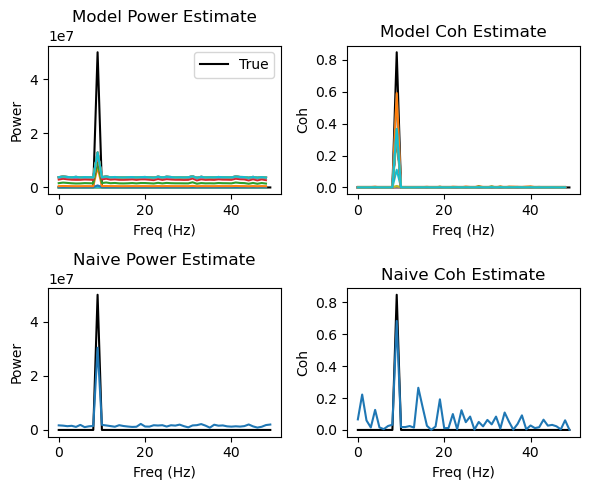

In [38]:
plot_itrs(0,20)

/projectnb/stephenlab/jtauber/cohlib/cohlib/mvcn.py:214: RuntimeWarning: invalid value encountered in divide
  t_coh = num/denom


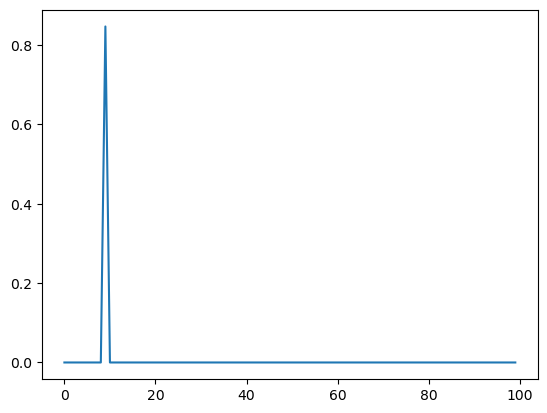

In [19]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
Gamma_inv_init = model_load['inv_init']
J = Gamma_est.shape[0]

Gamma_init = deconstruct_Gamma_full_real(Gamma_inv_init, K, 2*J, invert=True)

# plt.plot(Gamma_init[:,0,0].real)
# plt.plot(Gamma_zest[:50,0,0].real)

In [15]:
Gamma[:,0,0].real

array([5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+07, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
      

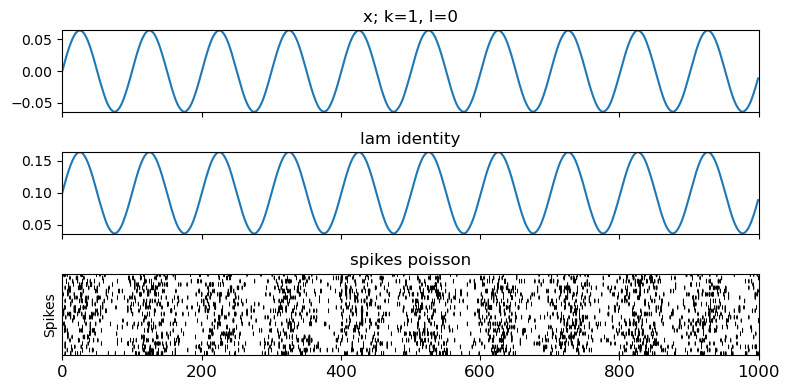

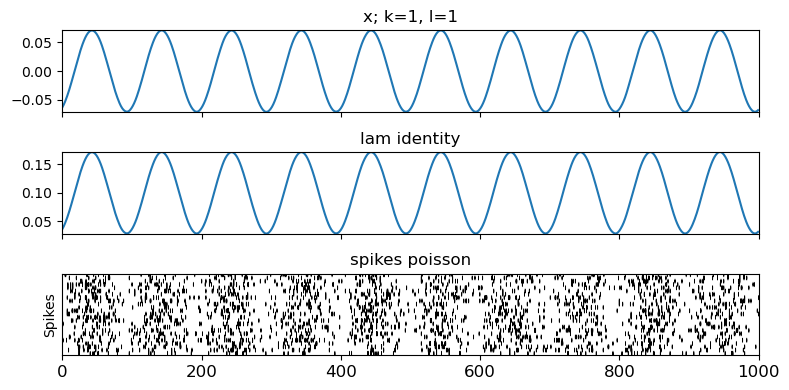

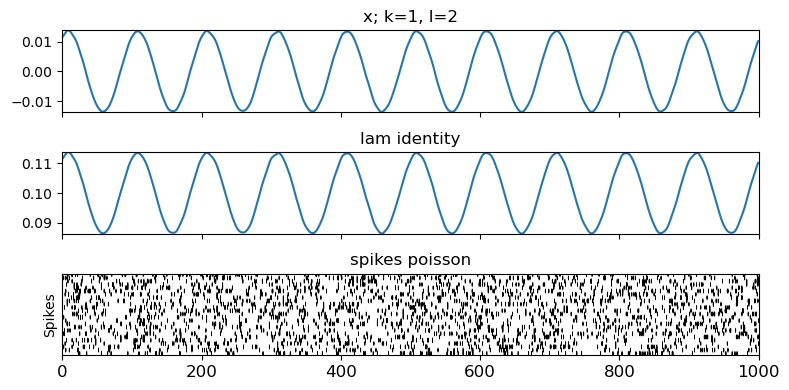

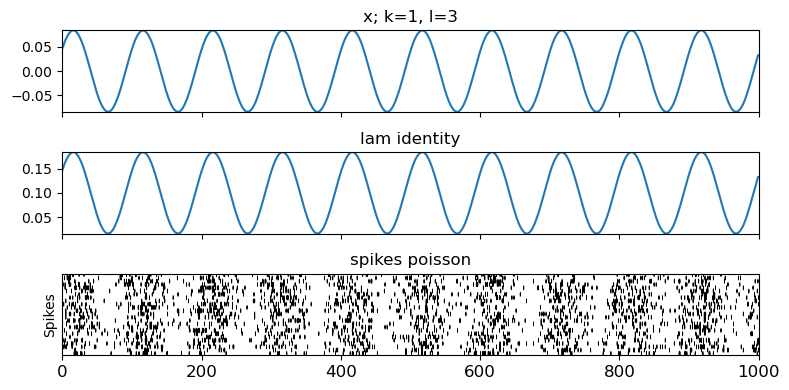

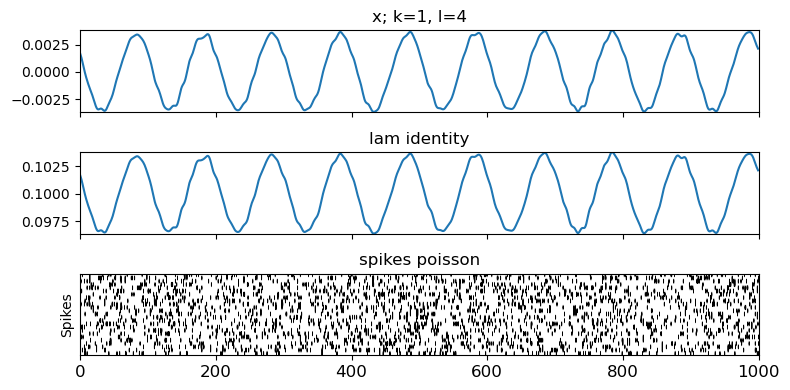

In [98]:
k = 1
l = 0
for l in range(5):
    fig, ax = plt.subplots(3,1,figsize=(8,4), sharex=True)
    ax[0].plot(xs[l,k,:])
    ax[0].set_title(f'x; k={k}, l={l}')
    ax[1].plot(lams[l,k,:])
    ax[1].set_title(f'lam identity')
    draw_raster_single(spikes[l,:,k,:], trange=[0,1000], ax = ax[2])
    ax[2].set_title(f'spikes poisson')
    ax[0].margins(0)
    ax[1].margins(0)

    plt.tight_layout()